# Лабораторная работа №1 по машинному обучению
### Выполнила Блистунова Валерия
### Группа М8О-401Б-18

#### Постановка задачи

Найти наборданных (датасет), для следующей лабораторной работы, и проанализировать его. Выявить проблемы набора данных, устранить их. Визуализировать зависимости, показать распределения некоторых признаков. Реализовать алгоритмы К ближайших соседа с использованием весов и Наивный Байесовский классификатор и сравнить с реализацией библиотеки sklearn.
#### Датасет

В качестве датасета я выбрала набор данных среди предложенных сообществом Kaggle для анализа и прогнозирования сердечного приступа (https://www.kaggle.com/rashikrahmanpritom/heart-attack-analysis-prediction-dataset). 
Данный набор включает в себя следущие параметры: 
1. Возраст людей (от 29 до 77 лет)
2. Пол (1- мужчина, 0- женщина)
3. Степень боли в груди (от 0 до 3)
4. Артериальное давление (от 94 до 200 мм.рт.ст.)
5. Холестерин (от 126 до 564 мг/дл)
6. Уровень сахара в крови (1- больше 120 мг/дл, 0- меньше 120 мг/дл)
7. Степень нарушений в результатах ЭКГ (от 0 до 2)
8. Максимальное значение пульса (от 71 до 202 ударов)
9. Стенокардия при физических нагрузках (1- да, 0- нет)
10. Предыдущий пик (от 0 до 6.2)

#### Проблемы в данных

Основываясь на медицинских данных, можно сделать вывод, что эта выборка является репрезентативной, т.к. все параметры принимают реальные значения, а также по совокупности этих параметров можно с большой точностью определить риск возникновения сердечного приступа.
Стоит отметить, что в наборе данных отсутствуют несовпадения и отсутствующая информация.

Подключение необходимых библиотек

In [1]:
import pandas as pd
import numpy as np
import sklearn as sk
import random as rd
import math
from collections import defaultdict
from pandas.plotting import scatter_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

Загрузка датасета и вывод первых строк

In [2]:
data = pd.read_csv('heart.csv')
data.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,52,1,0,125,212,0,1,168,0,1.0,2,2,3,0
1,53,1,0,140,203,1,0,155,1,3.1,0,0,3,0
2,70,1,0,145,174,0,1,125,1,2.6,0,0,3,0
3,61,1,0,148,203,0,1,161,0,0.0,2,1,3,0
4,62,0,0,138,294,1,1,106,0,1.9,1,3,2,0


In [3]:
data.shape

(1025, 14)

Нахождение корреляции, чтобы оценить какие факторы повышают вероятность появления проблем с сердцем. Визуализация зависимостей различных параметров.

In [4]:
data.corr()['target'].sort_values(ascending=False)

target      1.000000
cp          0.434854
thalach     0.422895
slope       0.345512
restecg     0.134468
fbs        -0.041164
chol       -0.099966
trestbps   -0.138772
age        -0.229324
sex        -0.279501
thal       -0.337838
ca         -0.382085
exang      -0.438029
oldpeak    -0.438441
Name: target, dtype: float64

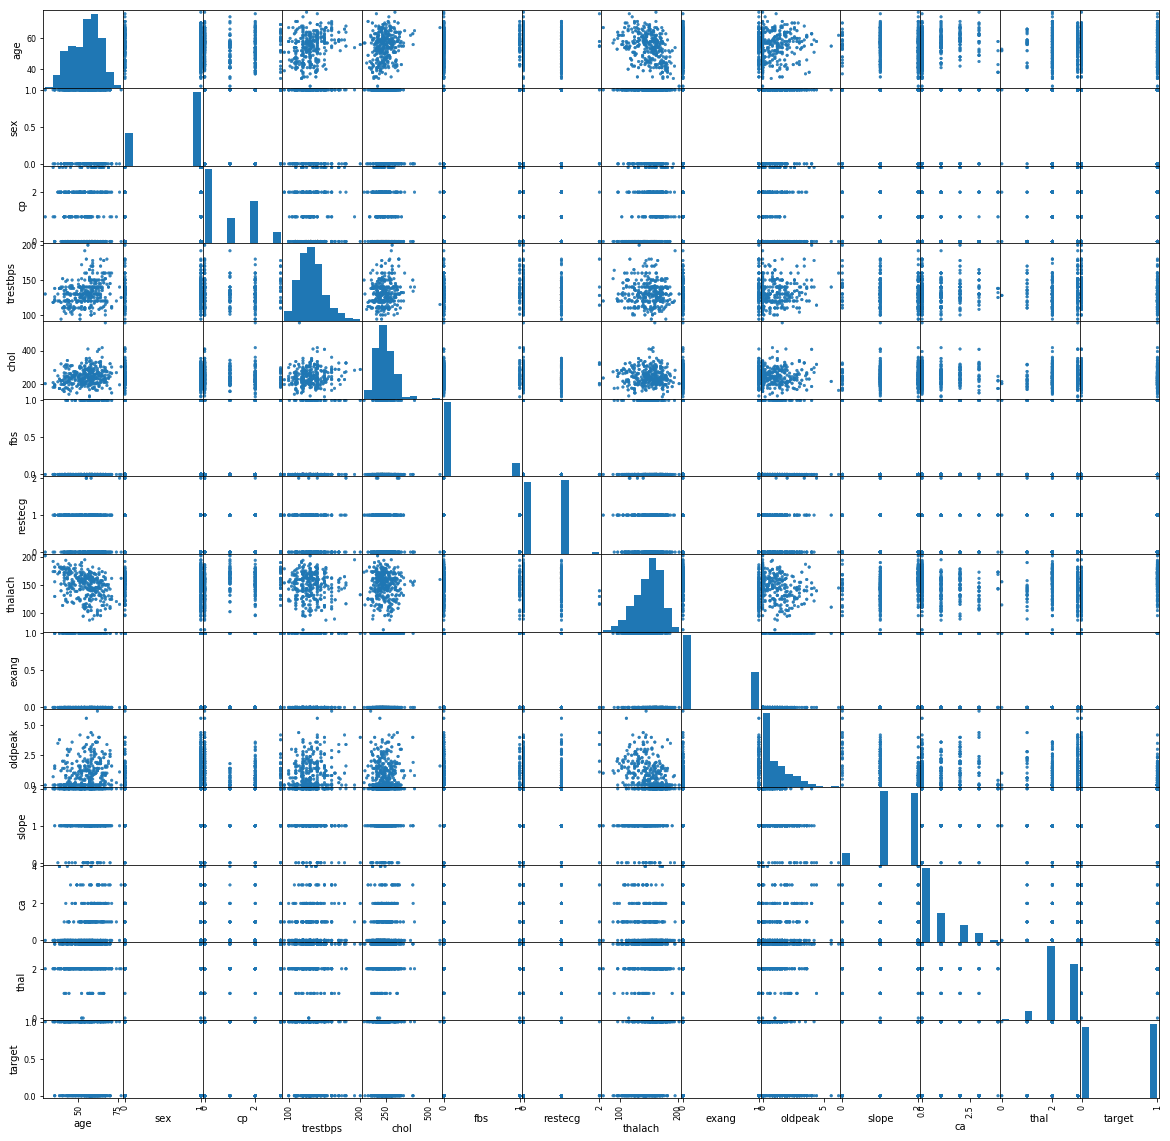

In [13]:
scatter_matrix(data, figsize=(20, 20), marker='.');

Разобьем данные на два класса: большой риск проблем с сердечно-сосудистой системой (target = 1) и незнаительный риск (target = 0). Предположим, что наибольшее влияние на возможный риск сердечно-сосудистых заболеваний имеет возраст людей и значение максимального пульса.

In [6]:
# Подготовка данных
def dataPreparing(data, split):
    X = data[0:1024]['age'].values
    Y = data[0:1024]['thalach'].values
    Z = data[0:1024]['target'].values
    req_data = []
    for i in range(len(X)):
        req_data.append([[X[i], Y[i]],Z[i]])
    train =[]
    test = []
    for i in range (len(req_data)):
        if rd.random() < split:
            train.append(req_data[i])
        else:
            test.append(req_data[i])
    return train, test
numberOfClasses = 2
k = 5
train, test = dataPreparing(data, 0.85)

#### KNN алгоритм
1. Собрать все данные
2. Вычисление Евклидова расстояния от новой точки данных х до всех остальных точек в множестве данных
3. Сортировка точек из множества данных в порядке возрастания расстояния до х
4. Прогноз ответа, используя ту же категорию, что и большинство К-ближайших к х данных

Вспомогательная функция, вычисляющая расстояние

In [7]:
def dist (a, b):
    return math.sqrt((a[0] - b[0])**2 + (a[1] - b[1])**2)

Реализация KNN алгоритма

In [8]:
def KNN (test, train, k):
    result = []
    for testPoint in test:
        distance = [[dist(testPoint[0], train[i][0]), train[i][1]] for i in range(len(train))]
        q = [0 for i in range(numberOfClasses)]

        for closedPoint in sorted(distance)[0:k]:
            if(closedPoint[0] != 0):
                q[closedPoint[1]] += 1 / closedPoint[0]**2

        result.append(q.index(max(q)))
    return result

#### Наивный Байесовский классификатор
Наивный байесовский алгоритм – это алгоритм классификации, основанный на теореме Байеса с допущением о независимости признаков.
Алгоритм
1. Преобразование набора данных в частотную таблицу
2. Создание таблицы правдоподобия, рассчитав соответствующие вероятности
3. С помощью теоремы Байеса вычисление апостериорной вероятности для каждого класса

Подготовка данных для Наивного Байесовского классификатора

In [9]:
# Вычисление среднего значения каждого атрибута для значения класса
def mean(num):
    return sum(num) / float(len(num))
# Рассчет стандартного отклонения каждого атрибута для значения класса
def stdev(num):
    avg = mean(num)
    variance = sum([pow(x-avg,2) for x in num])/float(len(num)-1)
    return math.sqrt(variance)
# Для значения класса мы можем рассчет среднего значения и стандартного отклонения для каждого атрибута
def summarize(d):
    summaries = []
    for i in range(len(d[0][0])):
        feat = [d[j][0][i] for j in range(len(d))]
        summaries.append((mean(feat), stdev(feat)))
    return summaries
def summarizeByClass(d):
    summaries = {}
    separated = {}
    # Разделение обучающего набора данных на экземпляры
    for inst in d:
        if (inst[-1] not in separated):
            separated[inst[-1]] = []
        separated[inst[-1]].append(inst)
    # Объединение
    for classValue, instances in separated.items():
        summaries[classValue] = summarize(instances)
    return summaries
# Вычисление гауссовской функции плотности вероятности
def calculateProbability(x, mean, stdev):
    exponent = math.exp(-((x-mean)**2/(2*stdev**2)))
    return (1 / (math.sqrt(2*math.pi) * stdev)) * exponent
# Вычисление вероятности класса 
def calculateClassProbabilities(summaries, inputVector):
    probabilities = {}
    for classValue, classSummaries in summaries.items():
        probabilities[classValue] = 1
        for i in range(len(classSummaries)):
            mean, stdev = classSummaries[i]
            x = inputVector[i]
            probabilities[classValue] *= calculateProbability(x, mean, stdev)
    return probabilities
# Вычисление вероятности экземпляра данных, принадлежащего каждому значению класса
def predict(summaries, inputVector):
    probabilities = calculateClassProbabilities(summaries, inputVector)
    bestLabel, bestProb = None, -1
    for classValue, probability in probabilities.items():
        if bestLabel is None or probability > bestProb:
            bestProb = probability
            bestLabel = classValue
    return bestLabel
# Оценивание точности модели. Прогнозы для каждого экземпляра данных в нашем тестовом наборе данных
def getPredictions(summaries, test):
    predictions = []
    for x in test:
        res = predict(summaries, x[0])
        predictions.append(res)
    return predictions
# Точность классификации
def getAccuracy(test, predictions):
    correct = 0
    for x in range(len(test)):
        if test[x][-1] == predictions[x]:
            correct += 1
    return (correct/float(len(test)))

Реализация Наивного Байесовского классификатора

In [10]:
def Bayes(test, train):
    summaries = summarizeByClass(train)
    predictions = getPredictions(summaries, test)
    return predictions

In [11]:
# KNN и Наивный Байесовский алгоритмы
result = KNN(test, train, k)
predictions = Bayes(test, train)

In [12]:
# Вывод результатов работы алгоритмов 
print('KNN:    ',result)
print('BAYES:  ', predictions)
print('true val:  ', [test[i][1] for i in range(len(test))])
accuracy = getAccuracy(test, predictions)
accuracyK = getAccuracy(test, result)
accuracyB = getAccuracy(test, predictions)
print('KNN accuracy = ', accuracyK, ' BAYES accuracy = ', accuracyB, '\n')
# Вывод работы библиотечных функций
knn = KNeighborsClassifier(n_neighbors=k, weights='distance')
X = []
Y = []
for i in range(len(train)):
    X.append(train[i][0])
    Y.append(train[i][1])
knn.fit(X, Y)
answ1 = knn.predict([test[i][0] for i in range(len(test))])
print('sklearn Knn:', answ1)
print('accuracy = ', getAccuracy(test, answ1), '\n')
nb = GaussianNB()
nb.fit(X, Y)
answ2 = nb.predict([test[i][0] for i in range(len(test))])
print('sklearn NB: ', answ2)
print('accuracy = ', getAccuracy(test, answ2))

KNN:     [0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1]
BAYES:   [0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1,

#### Вывод
Написанный и библиотечный Наивный Байесовский классификатор на данной выборке не отличаются в точности. Точность библиотечного KNN-алгоритма самая высокая, однако точность написанного алгоритма немного ниже.

#### Список литературы
1. https://habr.com/ru/post/470650/
2. https://www.machinelearningmastery.ru/naive-bayes-classifier-scratch-python/
3. https://habr.com/ru/post/149693/